<a href="https://colab.research.google.com/github/laviniaflorentina/neural_networks_dissertation/blob/master/experiment3_double_digit_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloads

In [0]:
import os.path
from IPython.display import clear_output

if not os.path.exists("data/train_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/train_minist.npz
  clear_output(wait=True)

if not os.path.exists("validation_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/validation_minist.npz
  clear_output(wait=True)

if not os.path.exists("test_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/test_minist.npz
  clear_output(wait=True)

!ls

sample_data  test_minist.npz  train_minist.npz	validation_minist.npz


### Imports

In [0]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator



def plot_train(train_history, train=True, validation=True, acc_name='Model accuracy', loss_name='Model loss'):
  legend = []
  
  fig, ax = plt.subplots()
  
  fig.tight_layout()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  #fig.savefig(acc_name+".png", dpi=100)
  
  # summarize history for accuracy
  if train:
    plt.plot(history.history['acc'])
    legend.append('train')
    
  if validation:
    plt.plot(history.history['val_acc'])
    legend.append('validation')
    
  plt.grid()
  plt.title(acc_name)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.xticks((np.arange(len(history.history["acc"]))), 
             (np.arange(len(history.history["acc"]))+1))
  plt.show()
  
  fig.tight_layout()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  #fig.savefig(loss_name+".png", dpi=100)
  
  legend = []
  
  # summarize history for loss
  if train:
    plt.plot(history.history['loss'])
    legend.append('train')
    
  if validation:
    plt.plot(history.history['val_loss'])
    legend.append('validation')
    
  plt.grid()
  plt.title(loss_name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.xticks((np.arange(len(history.history["acc"]))), 
             (np.arange(len(history.history["acc"]))+1))
  plt.show()
  
  return


def global_evaluation(true_labels, predicted_labels, avg='macro'):
  f1 = f1_score(true_labels, predicted_labels, average=avg)
  precision = precision_score(true_labels, predicted_labels, average=avg)
  recall = recall_score(true_labels, predicted_labels, average=avg)
  accuracy = accuracy_score(true_labels, predicted_labels)
  
  evaluation_table = pd.DataFrame({'Metric':["F1-score", "Precision", "Recall", "Accuracy"], "Value":[f1, precision, recall, accuracy] })
  
  return evaluation_table



def micro_evaluation(true_labels, predicted_labels, labels=list(range(10)), avg=None):
  f1 = f1_score(true_labels, predicted_labels, average=avg)
  precision = precision_score(true_labels, predicted_labels, average=avg)
  recall = recall_score(true_labels, predicted_labels, average=avg)
  evaluation_table = pd.DataFrame({'Labels':labels, "precision":precision, "recall":recall, "f1":f1 })
  
  return evaluation_table




def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         image="confusion_matrix.png"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig(image, dpi=100)
    return ax

Using TensorFlow backend.


### Read Data

In [0]:
npzfile = np.load("train_minist.npz")
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']

npzfile = np.load("validation_minist.npz")
X_validation = npzfile['arr_0']
y_validation = npzfile['arr_1']

npzfile = np.load("test_minist.npz")
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']

print("Train",X_train.shape)
print("Valid",X_validation.shape)
print("Test ",X_test.shape)

Train (3000, 28, 28)
Valid (3000, 28, 28)
Test  (10000, 28, 28)


### Train-Validation Dictionary

In [0]:
train_dictionary = {index:[] for index in range(10)}
[train_dictionary[label].append(image) for image, label in zip(X_train, y_train)];

validation_dictionary = {index:[] for index in range(10)}
[validation_dictionary[label].append(image) for image, label in zip(X_validation, y_validation)];

In [0]:
sum([len(validation_dictionary[i]) for i in range(10)])

3000

### Double Digit

In [0]:
X_tr_double, y_tr_double = [], []
values = 4

for key in train_dictionary.keys():
  # for each value in key
  for value in train_dictionary[key]:
    # for each key in dictionary
    for tmp_key in train_dictionary.keys():
      for _ in range(values):
        pick = random.randint(0, (len(train_dictionary[tmp_key])-1))
        # concatenate
        large_image = np.concatenate((train_dictionary[tmp_key][pick], value), axis=1)
        large_label = tmp_key * 10 + key
        X_tr_double.append(large_image)
        y_tr_double.append(large_label)
X_tr_double = np.array(X_tr_double)
y_tr_double = np.array(y_tr_double)   

print(X_tr_double.shape)


X_vl_double, y_vl_double = [], []

for key in validation_dictionary.keys():
  # for each value in key
  for value in validation_dictionary[key]:
    # for each key in dictionary
    for tmp_key in validation_dictionary.keys():
      pick = random.randint(0, (len(validation_dictionary[tmp_key])-1))
      # concatenate
      large_image = np.concatenate((validation_dictionary[tmp_key][pick], value), axis=1)
      large_label = tmp_key * 10 + key
      X_vl_double.append(large_image)
      y_vl_double.append(large_label)
X_vl_double = np.array(X_vl_double)
y_vl_double = np.array(y_vl_double)

print(X_vl_double.shape)


X_test_double, y_test_double = [], []

for image, label in zip(X_test, y_test):
  first_image = np.zeros((image.shape[0],image.shape[1]))
  large_image = np.concatenate((first_image, image), axis=1)
  X_test_double.append(large_image)
  y_test_double.append(label)
        
X_test_double = np.array(X_test_double)
y_test_double = np.array(y_test_double)


print(X_test_double.shape)

(120000, 28, 56)
(30000, 28, 56)
(10000, 28, 56)


#### Sample

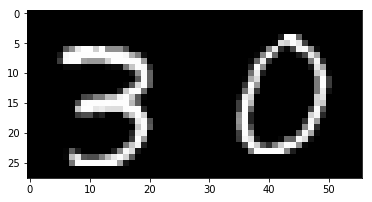

30


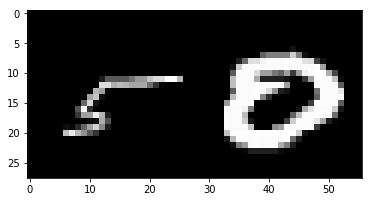

50


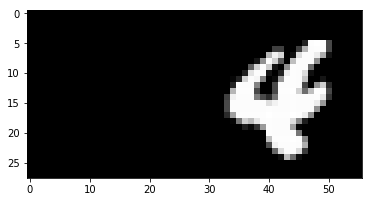

4


In [0]:
i = random.randint(0, 100)
# plot image
plt.imshow(X_tr_double[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_tr_double[i])

# plot image
plt.imshow(X_vl_double[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_vl_double[i])

# plot image
plt.imshow(X_test_double[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_test_double[i])

### Model CNN

W0905 19:51:02.531038 139738119157632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 19:51:02.567850 139738119157632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 19:51:02.574831 139738119157632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 19:51:02.590336 139738119157632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 19:51:02.591719 1397381191

Train on 120000 samples, validate on 30000 samples
Epoch 1/20
120000/120000 [==============================] - 12s 100us/step - loss: 0.7218 - acc: 0.8027 - val_loss: 0.3923 - val_acc: 0.8824
Epoch 2/20
120000/120000 [==============================] - 9s 75us/step - loss: 0.0931 - acc: 0.9738 - val_loss: 0.3536 - val_acc: 0.9042
Epoch 3/20
120000/120000 [==============================] - 9s 75us/step - loss: 0.0297 - acc: 0.9927 - val_loss: 0.3794 - val_acc: 0.9095
Epoch 4/20
120000/120000 [==============================] - 9s 75us/step - loss: 0.0146 - acc: 0.9965 - val_loss: 0.3997 - val_acc: 0.9123
Epoch 5/20
120000/120000 [==============================] - 9s 76us/step - loss: 0.0136 - acc: 0.9962 - val_loss: 0.4029 - val_acc: 0.9119
Epoch 6/20
120000/120000 [==============================] - 9s 75us/step - loss: 0.0097 - acc: 0.9973 - val_loss: 0.4691 - val_acc: 0.9082
Epoch 7/20
120000/120000 [==============================] - 9s 75us/step - loss: 0.0116 - acc: 0.9964 - val_loss:

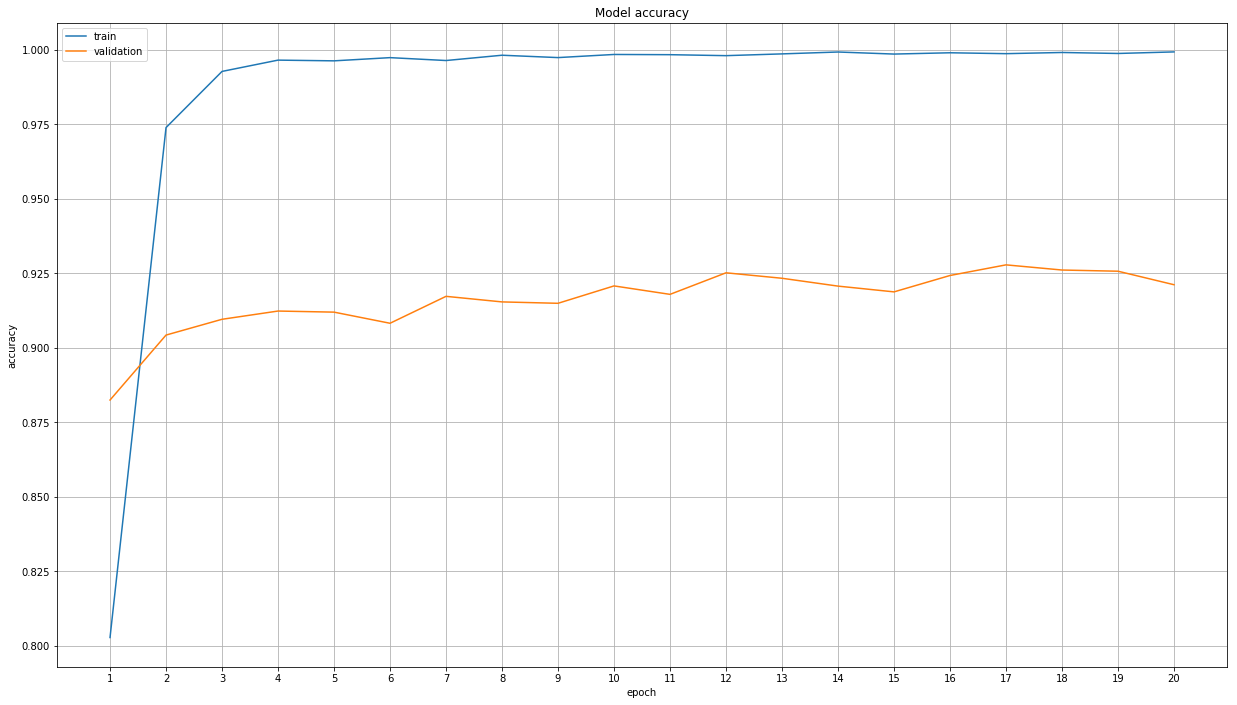

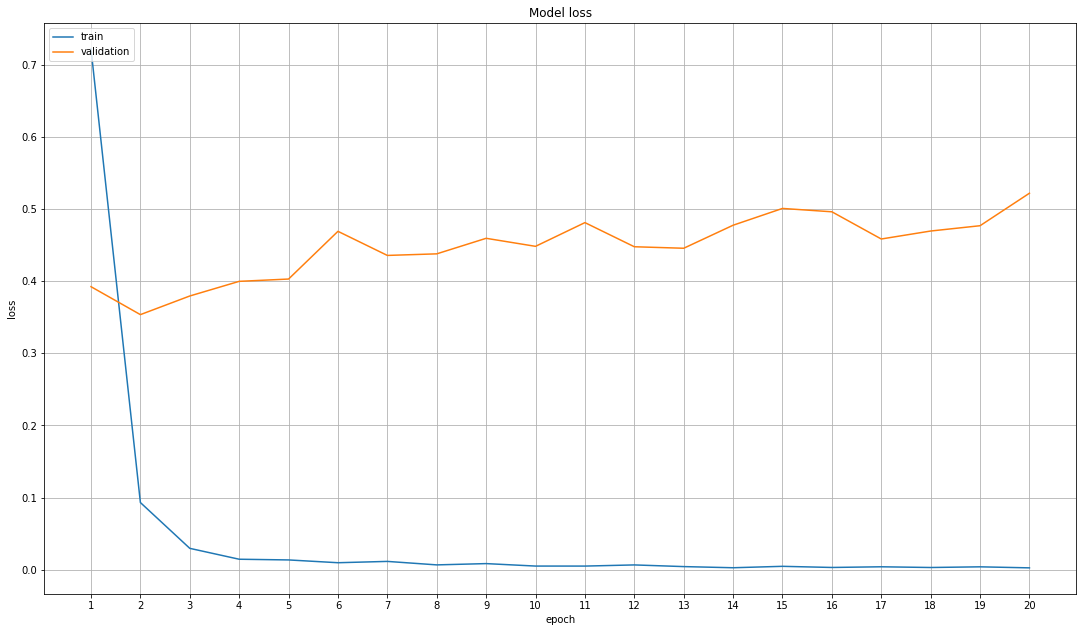

Confusion matrix, without normalization
[[ 961    0    0    0    0    1    6    3    8    1]
 [   0 1087    3   10    1    0    2    2   30    0]
 [   3    0  976   17    5    0    1   18   10    2]
 [   0    0    2  989    0    3    0    2   13    1]
 [   1    0    1    0  946    0    6    0    9   19]
 [   3    0    0   16    1  855    3    2   12    0]
 [   4    2    0    0    5    4  938    0    5    0]
 [   0    1   15    7    1    1    0  984   10    9]
 [   1    0    2    1    3    0    1    2  959    5]
 [   7    0    0    1    9    4    0    7   12  969]]
Normalized confusion matrix
[[9.80612245e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.02040816e-03 6.12244898e-03 3.06122449e-03
  8.16326531e-03 1.02040816e-03]
 [0.00000000e+00 9.57709251e-01 2.64317181e-03 8.81057269e-03
  8.81057269e-04 0.00000000e+00 1.76211454e-03 1.76211454e-03
  2.64317181e-02 0.00000000e+00]
 [2.90697674e-03 0.00000000e+00 9.45736434e-01 1.64728682e-02
  4.84496124e-03 0.000000

,Metric,Value
0,F1-score,0.966519
1,Precision,0.967017
2,Recall,0.966640
3,Accuracy,0.966400


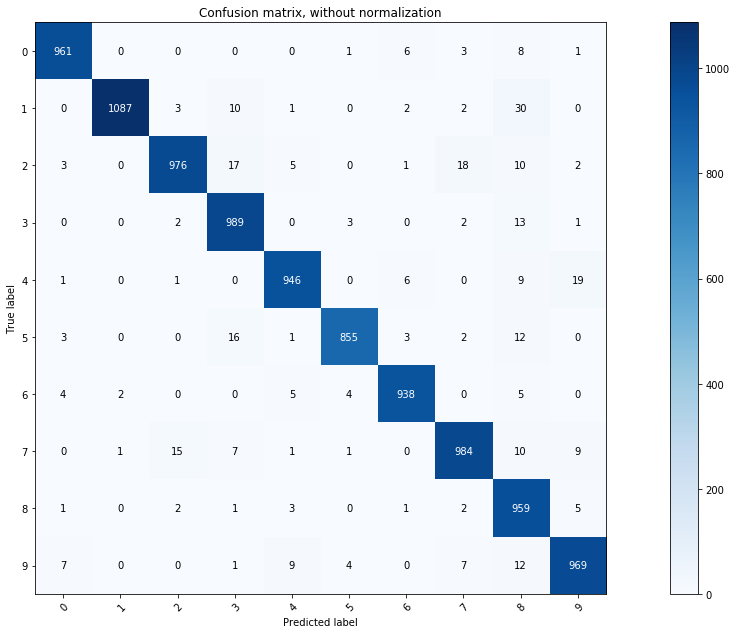

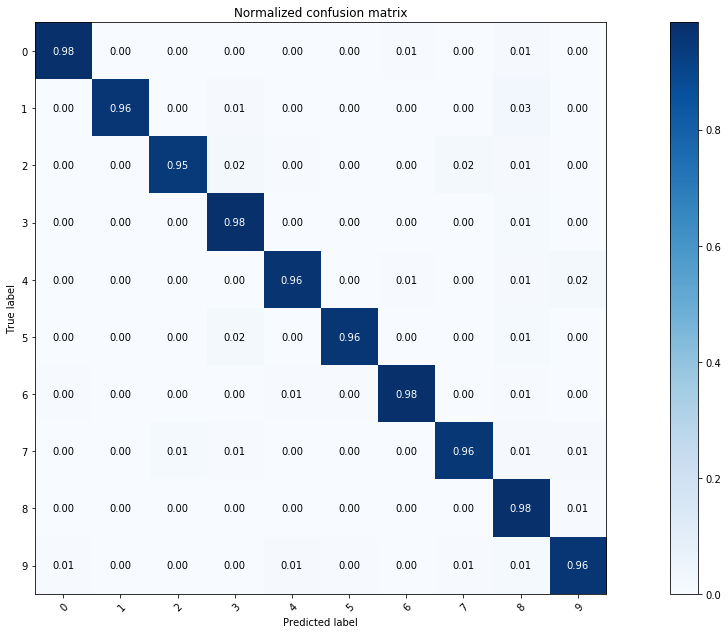

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
import random
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle


K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


def scale_data(images, labels, number_classes=100):

#   images, labels = shuffle(images, labels)
  
  scaled_images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2]).astype('float32')
  
  # normalize inputs from 0-255 to 0-1
  # importantfor NN - learn faster
  scaled_images = scaled_images / 255

  # one hot encode outputs
  scaled_labels = np_utils.to_categorical(labels, num_classes=number_classes)
  return scaled_images, scaled_labels

X_train_sc, y_train_sc = scale_data(images=X_tr_double, labels=y_tr_double, number_classes=100)
X_valid_sc, y_valid_sc = scale_data(images=X_vl_double, labels=y_vl_double, number_classes=100)
X_test_sc, _ = scale_data(images=X_test_double, labels=y_test_double, number_classes=100)


# create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=X_train_sc.shape[1:], activation='relu'))      # NOTA !!!! CONVOLUTION
model.add(MaxPooling2D(pool_size=(2, 2)))     # LAYER DE MICSORARE (IA PIXELUL CU VALOARE MAXIMA)
model.add(Dropout(0.2)) #seteaza valori pe zero random din matrici
model.add(Flatten()) # face orice dimensiune intr-un vector
model.add(Dense(128, activation='relu')) # NN normal layer
model.add(Dense(y_train_sc.shape[-1], activation='softmax')) # NN normal layer
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history = model.fit(X_train_sc, y_train_sc, validation_data=(X_valid_sc, y_valid_sc), epochs=20, batch_size=200, verbose=1)

# plot history training
plot_train(train_history=history, 
           train=True, 
           validation=True)

# predicitons
y_predicted = model.predict_classes(X_test_sc)
y_predicted = np.array([number%10 for number in y_predicted])

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=False, image="ex3_double_digit_cnn_confusion_matrix_notnormalized.png")

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=True, image="ex3_double_digit_cnn_confusion_matrix_normalized.png")

baseline_cnn_global_evaluation = global_evaluation(y_test, y_predicted)

baseline_cnn_global_evaluation.to_csv("ex3_double_digit_cnn_global_evaluation.csv")

baseline_cnn_global_evaluation

In [0]:
baseline_cnn_micro_evaluation = micro_evaluation(y_test, y_predicted)

baseline_cnn_micro_evaluation.to_csv("ex3_double_digit_cnn_micro_evaluation.csv")

baseline_cnn_micro_evaluation

,Labels,precision,recall,f1
0,0,0.980612,0.980612,0.980612
1,1,0.997248,0.957709,0.977079
2,2,0.976977,0.945736,0.961103
3,3,0.950048,0.979208,0.964408
4,4,0.974253,0.963340,0.968766
5,5,0.985023,0.958520,0.971591
6,6,0.980146,0.979123,0.979634
7,7,0.964706,0.957198,0.960938
8,8,0.897940,0.984600,0.939275
9,9,0.963221,0.960357,0.961787


### Model diagram

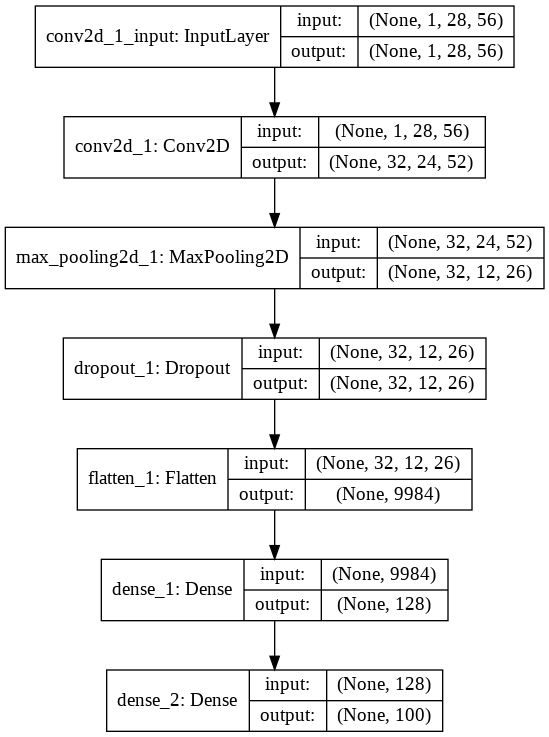

In [0]:
# image model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
Image('cnn_model.png')